## CNN visual

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
%matplotlib inline

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import keras.backend as K

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import pandas as pd
import cv2
import scipy.misc
import re
from math import ceil

K.set_learning_phase(0)

Using TensorFlow backend.


In [4]:
test = pd.read_csv("../res_csv/kfold/test/testing_noballaug_cross_k1.csv")

fn = test[(test["y_true"] == 1) & (test["y_pred"] < 0.5)].sort_values("y_pred")
tn = test[(test["y_true"] == 0) & (test["y_pred"] < 0.5)].sort_values("y_pred")
fp = test[(test["y_true"] == 0) & (test["y_pred"] > 0.95)].sort_values("y_pred", ascending = False)
tp = test[(test["y_true"] == 1) & (test["y_pred"] > 0.95)].sort_values("y_pred", ascending = False)

In [5]:
model = load_model('/home/jimmy15923/Project_theta/Advantech/model/model_noballaug_cross_k1.h5')

In [6]:
model = model.get_layer("model_1")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 206, 206, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 100, 100, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 100, 100, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [7]:
file = list(tp.png_name)[0]
img = np.array(Image.open(file))   
img = np.expand_dims(img, axis=0) 
in_img = preprocess_input(img.astype("float32"))
print(in_img.shape)

(1, 200, 200, 3)


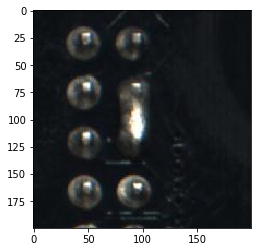

In [8]:
plt.imshow(img[0])
plt.show()

In [9]:
last_conv_layer = model.get_layer('activation_40').output

relu_out = K.function([model.get_layer('input_1').input], 
                      [model.get_layer('output').output, last_conv_layer])

In [10]:
#get filter output and score
output, last_convlayer_value = relu_out([in_img])  

In [27]:
dense_weight = model.get_layer('output').get_weights()[0]
print(last_convlayer_value.shape)
print(dense_weight.shape)

(1, 13, 13, 1024)
(1024, 2)


In [28]:
last_convlayer_value1 = last_convlayer_value[0]
for i in range(1024):
    last_convlayer_value1[:,:,i] *= dense_weight[:, 0][i]
print(last_convlayer_value1.shape)

(13, 13, 1024)


In [29]:
cam = np.sum(last_convlayer_value1, axis = 2)
print(cam.shape)

(13, 13)


In [26]:
cam2 = np.dot(last_convlayer_value[0], dense_weight[:, 0])

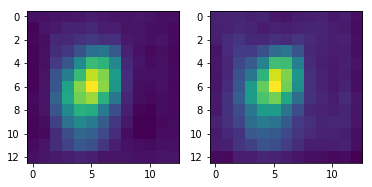

In [15]:
plt.subplot(121)
plt.imshow(cam)
plt.subplot(122)
plt.imshow(cam2)

A056_3_13_1111_81Bri.png
score: [  2.98492964e-08   1.00000000e+00]
img


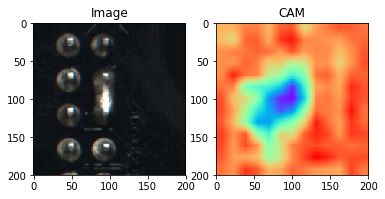

In [30]:
cam_big = cv2.resize(cam, (img[0].shape[0], img[0].shape[1]), interpolation = cv2.INTER_LINEAR)

# show img
print(os.path.basename(file))
print("score: "+str(output[0]))
print("img")
plt.subplot(121)
plt.title("Image")
plt.imshow(img[0])

plt.subplot(122)
plt.title("CAM")
plt.imshow(cam_big, cmap='rainbow')
plt.show()

## Grad-CAM

In [17]:
model = load_model('/home/jimmy15923/Project_theta/Advantech/model/model_noballaug_cross_k1.h5')

In [18]:
model = model.get_layer("model_1")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 206, 206, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 100, 100, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 100, 100, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [38]:
file = list(tp.png_name)[1]
img = np.array(Image.open(file))   
img = np.expand_dims(img, axis=0) 
in_img = preprocess_input(img.astype("float32"))
print(in_img.shape)

(1, 200, 200, 3)


In [49]:
last_conv_layer = model.get_layer('activation_40').output

grads = K.gradients(model.get_layer('output').output[:,1], last_conv_layer)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))


iterate = K.function([model.get_layer("input_1").input], 
                    [grads, last_conv_layer])

In [47]:
grads

<tf.Tensor 'gradients_5/global_average_pooling2d_2_1/Mean_grad/truediv:0' shape=(?, 13, 13, 1024) dtype=float32>

In [46]:
pooled_grads_value, conv_layer_output_value = iterate([in_img])

print(conv_layer_output_value.shape)
print(pooled_grads_value.shape)

(1, 13, 13, 1024)
(1, 13, 13, 1024)


In [51]:
a  = conv_layer_output_value * pooled_grads_value

In [41]:
conv_layer_output_value = conv_layer_output_value[0]
for i in range(1024):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
gradcam = np.sum(a[0], axis=2)
print(gradcam.shape)

(13, 13)


In [59]:
gradcam = np.sum(a[0], axis=2)
print(gradcam.shape)

(13, 13)


In [60]:
gradcam = np.maximum(gradcam, 0)
gradcam /= np.max(gradcam)
gradcam =cv2.resize(gradcam, (img[0].shape[0], img[0].shape[1]))

In [61]:
a.shape

(1, 13, 13, 1024)

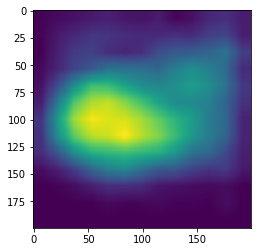

In [62]:
plt.imshow(gradcam)

A038_2_20_0560_41Bri.png
score: [  2.98492964e-08   1.00000000e+00]
img


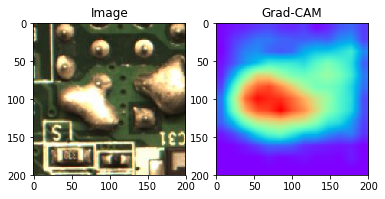

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplo'

In [52]:
# show img
print(os.path.basename(file))
print("score: "+str(output[0]))
print("img")
plt.subplot(121)
plt.title("Image")
plt.imshow(img[0])

plt.subplot(122)
plt.title("Grad-CAM")
plt.imshow(gradcam, cmap='rainbow')
plt.show()
plt.subplo(133)
plt.imshow(a)

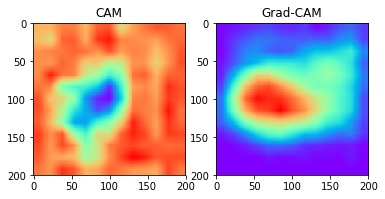

In [44]:
plt.subplot(121)
plt.title("CAM")
plt.imshow(cam_big, cmap='rainbow')

plt.subplot(122)
plt.title("Grad-CAM")
plt.imshow(gradcam, cmap='rainbow')
plt.show()